# Negative L1 norm prior experiment

This code attempts to learn the 4D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 4

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 378.3979187011719
iteration 0 loss 558.5997924804688


iteration 5000 loss 0.022655881941318512


iteration 10000 loss 0.013660416938364506


iteration 15000 loss 0.010817970149219036


iteration 20000 loss 0.007428640499711037


iteration 25000 loss 0.006252907682210207


iteration 30000 loss 0.005018122959882021


iteration 35000 loss 0.004288775846362114


iteration 40000 loss 0.00367086473852396


iteration 45000 loss 0.003336779773235321


iteration 50000 loss 0.0029961185064166784


iteration 55000 loss 0.002848581876605749


iteration 60000 loss 0.002625632332637906


iteration 65000 loss 0.0023883762769401073


iteration 70000 loss 0.002221795730292797


iteration 75000 loss 0.002030017087236047


iteration 80000 loss 0.0018650024430826306


iteration 85000 loss 0.0017222499009221792


iteration 90000 loss 0.001610893988981843


iteration 95000 loss 0.0014692917466163635


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0014008268481120467


iteration 105000 loss 0.0013273562071844935


iteration 110000 loss 0.0012242499506101012


iteration 115000 loss 0.001151268370449543


iteration 120000 loss 0.0010901142377406359


iteration 125000 loss 0.001037399284541607


iteration 130000 loss 0.0009877198608592153


iteration 135000 loss 0.0009448009077459574


iteration 140000 loss 0.0009068327490240335


iteration 145000 loss 0.0008703952771611512


iteration 150000 loss 0.0008393987664021552


iteration 155000 loss 0.0008093021460808814


iteration 160000 loss 0.0007923031807877123


iteration 165000 loss 0.0007577132782898843


iteration 170000 loss 0.0007347005885094404


iteration 175000 loss 0.0007135109044611454


iteration 180000 loss 0.0006940983585081995


iteration 185000 loss 0.0006756993825547397


iteration 190000 loss 0.0006588516407646239


iteration 195000 loss 0.0006428014603443444


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0006276735221035779


iteration 205000 loss 0.0006186439422890544


iteration 210000 loss 0.0006065693451091647


iteration 215000 loss 0.0005934109794907272


iteration 220000 loss 0.0005813786410726607


iteration 225000 loss 0.0005701662157662213


iteration 230000 loss 0.0005594686372205615


iteration 235000 loss 0.0005484336288645864


iteration 240000 loss 0.0005387116107158363


iteration 245000 loss 0.0005288022803142667


iteration 250000 loss 0.0005193964461795986


iteration 255000 loss 0.0005098740221001208


iteration 260000 loss 0.0005020786193199456


iteration 265000 loss 0.0004943269887007773


iteration 270000 loss 0.0004865395021624863


iteration 275000 loss 0.0004785868513863534


iteration 280000 loss 0.00047114217886701226


iteration 285000 loss 0.0004638272221200168


iteration 290000 loss 0.0004569868033286184


iteration 295000 loss 0.00045014204806648195


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00044345998321659863


iteration 305000 loss 0.0004416180890984833


iteration 310000 loss 0.0004347746726125479


iteration 315000 loss 0.0004281810251995921


iteration 320000 loss 0.0004217626410536468


iteration 325000 loss 0.0004154047928750515


iteration 330000 loss 0.0004093289317097515


iteration 335000 loss 0.00040356710087507963


iteration 340000 loss 0.00039789220318198204


iteration 345000 loss 0.00039236960583366454


iteration 350000 loss 0.0003872161905746907


iteration 355000 loss 0.0003823021543212235


iteration 360000 loss 0.00037747767055407166


iteration 365000 loss 0.000372700160369277


iteration 370000 loss 0.0003678673238027841


iteration 375000 loss 0.0003631695290096104


iteration 380000 loss 0.0003587084647733718


iteration 385000 loss 0.0003543715283740312


iteration 390000 loss 0.00034995609894394875


iteration 395000 loss 0.00034581025829538703


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00034173225867561996


iteration 405000 loss 0.00034085341030731797


iteration 410000 loss 0.00033937726402655244


iteration 415000 loss 0.00033793473266996443


iteration 420000 loss 0.0003365172597113997


iteration 425000 loss 0.00033511847141198814


iteration 430000 loss 0.0003337359812576324


iteration 435000 loss 0.00033236845047213137


iteration 440000 loss 0.000331018993165344


iteration 445000 loss 0.0003296886570751667


iteration 450000 loss 0.0003283777041360736


iteration 455000 loss 0.00032708750222809613


iteration 460000 loss 0.0003258078941144049


iteration 465000 loss 0.00032454170286655426


iteration 470000 loss 0.00032328732777386904


iteration 475000 loss 0.0003220439830329269


iteration 480000 loss 0.0003208112029824406


iteration 485000 loss 0.000319590384606272


iteration 490000 loss 0.00031837966525927186


iteration 495000 loss 0.0003171788703184575


L2 loss -- Plot

loss 90.88477325439453


loss 37.7672119140625


loss 9.475250244140625


loss -10.19554328918457


loss -22.62305450439453


loss -29.676294326782227


loss -33.529842376708984


loss -35.49184036254883


loss -36.34176254272461


loss -36.633522033691406


loss -36.70847702026367


loss -36.72191619873047


loss -36.72343063354492


loss -36.723533630371094


loss -36.72352981567383


loss -36.723533630371094


loss -36.723533630371094


loss -36.723533630371094


loss -36.723533630371094


loss -36.72353744506836


loss -36.72353744506836


loss -36.723533630371094


loss -36.723533630371094


loss -36.72352981567383


loss -36.72353744506836


loss -36.723533630371094


loss -36.72353744506836


loss -36.723533630371094


loss -36.723533630371094


loss -36.72353744506836


loss -36.723533630371094


loss -36.723533630371094


loss -36.723533630371094


loss -36.723533630371094


loss -36.72353744506836


loss -36.72352600097656


loss -36.723533630371094


loss -36.723533630371094


loss -36.723533630371094


loss -36.723533630371094


final mse:  3.5608483273108504e-08
max, min: 3.002219 -2.9904437
loss 90.88477325439453


loss 38.07159423828125


loss 9.523509979248047


loss -10.340696334838867


loss -22.62701988220215


loss -29.542991638183594


loss -33.367671966552734


loss -35.34587860107422


loss -36.21321105957031


loss -36.51192855834961


loss -36.58771514892578


loss -36.6008415222168


loss -36.60224533081055


loss -36.602325439453125


loss -36.602325439453125


loss -36.602325439453125


loss -36.60232925415039


loss -36.60232162475586


loss -36.602325439453125


loss -36.60232925415039


loss -36.60232925415039


loss -36.60232925415039


loss -36.60232925415039


loss -36.602317810058594


loss -36.60232925415039


loss -36.602325439453125


loss -36.602325439453125


loss -36.60232162475586


loss -36.602325439453125


loss -36.60232925415039


loss -36.602317810058594


loss -36.602325439453125


loss -36.602325439453125


loss -36.602325439453125


loss -36.60232925415039


loss -36.60232925415039


loss -36.602325439453125


loss -36.602325439453125


loss -36.602325439453125


loss -36.60232162475586


final mse:  2.139330668171624e-08
max, min: 2.995243 -2.9946938


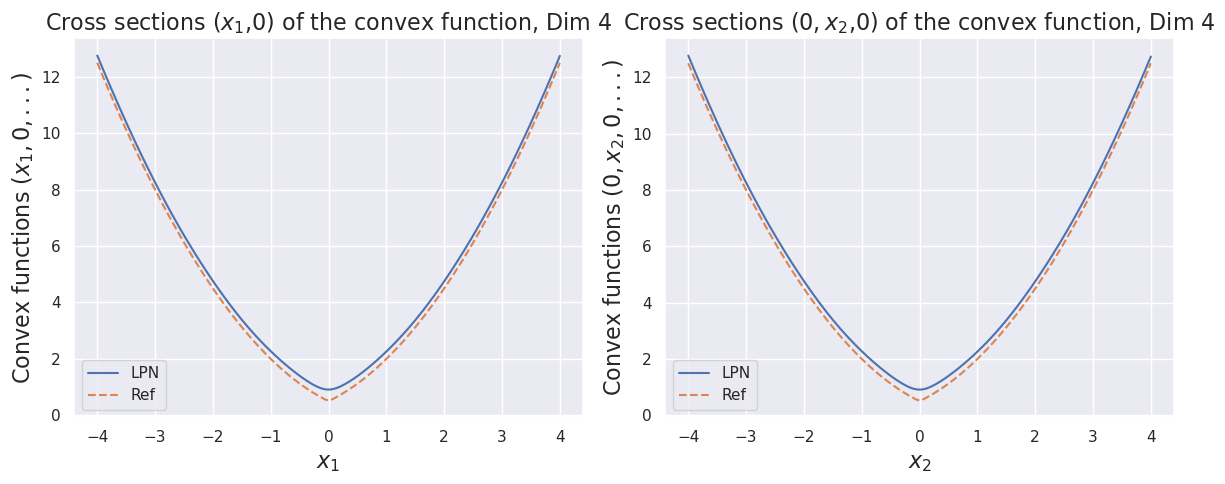

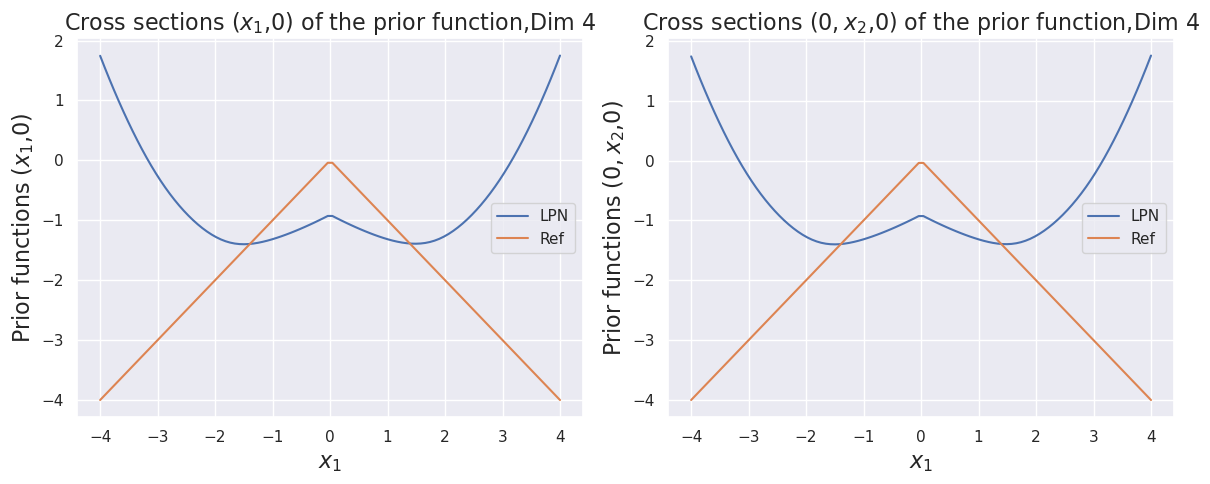

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 137.07174682617188
iteration 0 loss 1946.337158203125


iteration 5000 loss 0.024736633524298668


iteration 10000 loss 0.009892238304018974


iteration 15000 loss 0.005330467130988836


iteration 20000 loss 0.004730004817247391


iteration 25000 loss 0.003687177086248994


iteration 30000 loss 0.002782525261864066


iteration 35000 loss 0.0024324452970176935


iteration 40000 loss 0.002211549784988165


iteration 45000 loss 0.0019709505140781403


iteration 50000 loss 0.0019170650048181415


iteration 55000 loss 0.001788093475624919


iteration 60000 loss 0.0016137989005073905


iteration 65000 loss 0.0009175798040814698


iteration 70000 loss 0.0007829679525457323


iteration 75000 loss 0.0007329731597565114


iteration 80000 loss 0.0006216677720658481


iteration 85000 loss 0.0005733636789955199


iteration 90000 loss 0.0007793877157382667


iteration 95000 loss 0.0005213497788645327


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0004210963088553399


iteration 105000 loss 0.00036409409949555993


iteration 110000 loss 0.0003132691199425608


iteration 115000 loss 0.00028025906067341566


iteration 120000 loss 0.000255733379162848


iteration 125000 loss 0.00023545106523670256


iteration 130000 loss 0.00021876086248084903


iteration 135000 loss 0.00020433138706721365


iteration 140000 loss 0.00020124620641581714


iteration 145000 loss 0.00018021387222688645


iteration 150000 loss 0.0001697125844657421


iteration 155000 loss 0.0001605453435331583


iteration 160000 loss 0.00015184879885055125


iteration 165000 loss 0.00014447109424509108


iteration 170000 loss 0.00013731879880651832


iteration 175000 loss 0.00013081447104923427


iteration 180000 loss 0.00012472299567889422


iteration 185000 loss 0.00011911858018720523


iteration 190000 loss 0.00011418090434744954


iteration 195000 loss 0.00010997459321515635


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00010481700883246958


iteration 205000 loss 0.0001030637213261798


iteration 210000 loss 9.876333933789283e-05


iteration 215000 loss 9.450742072658613e-05


iteration 220000 loss 9.095319546759129e-05


iteration 225000 loss 8.766412793193012e-05


iteration 230000 loss 8.443997649010271e-05


iteration 235000 loss 8.142890874296427e-05


iteration 240000 loss 7.86824821261689e-05


iteration 245000 loss 7.604595884913579e-05


iteration 250000 loss 7.354281115112826e-05


iteration 255000 loss 7.128509605536237e-05


iteration 260000 loss 6.892278179293498e-05


iteration 265000 loss 6.666911212960258e-05


iteration 270000 loss 6.433254020521417e-05


iteration 275000 loss 6.208404374774545e-05


iteration 280000 loss 6.011898221913725e-05


iteration 285000 loss 5.818970748805441e-05


iteration 290000 loss 5.6579039664939046e-05


iteration 295000 loss 5.498697646544315e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 5.356726614991203e-05


iteration 305000 loss 5.289577165967785e-05


iteration 310000 loss 5.12720289407298e-05


iteration 315000 loss 4.991022069589235e-05


iteration 320000 loss 4.865443042945117e-05


iteration 325000 loss 4.747864295495674e-05


iteration 330000 loss 4.636920493794605e-05


iteration 335000 loss 4.529445504886098e-05


iteration 340000 loss 4.4200853153597564e-05


iteration 345000 loss 4.333156903157942e-05


iteration 350000 loss 4.249575795256533e-05


iteration 355000 loss 4.159344098297879e-05


iteration 360000 loss 4.0855316910892725e-05


iteration 365000 loss 4.0216444176621735e-05


iteration 370000 loss 3.9554881368530914e-05


iteration 375000 loss 3.894499968737364e-05


iteration 380000 loss 3.836610630969517e-05


iteration 385000 loss 3.778188693104312e-05


iteration 390000 loss 3.7208592402748764e-05


iteration 395000 loss 3.6747394915437326e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.625443423516117e-05


iteration 405000 loss 3.6160898162052035e-05


iteration 410000 loss 3.573302092263475e-05


iteration 415000 loss 3.5281216696603224e-05


iteration 420000 loss 3.4854430850828066e-05


iteration 425000 loss 3.444735557422973e-05


iteration 430000 loss 3.405777897569351e-05


iteration 435000 loss 3.368395482539199e-05


iteration 440000 loss 3.3322929084533826e-05


iteration 445000 loss 3.297389412182383e-05


iteration 450000 loss 3.2635558454785496e-05


iteration 455000 loss 3.230691800126806e-05


iteration 460000 loss 3.198802369297482e-05


iteration 465000 loss 3.1678871891926974e-05


iteration 470000 loss 3.137898238492198e-05


iteration 475000 loss 3.1088809919310734e-05


iteration 480000 loss 3.0808118026470765e-05


iteration 485000 loss 3.053498949157074e-05


iteration 490000 loss 3.026838749065064e-05


iteration 495000 loss 3.0009865440661088e-05


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


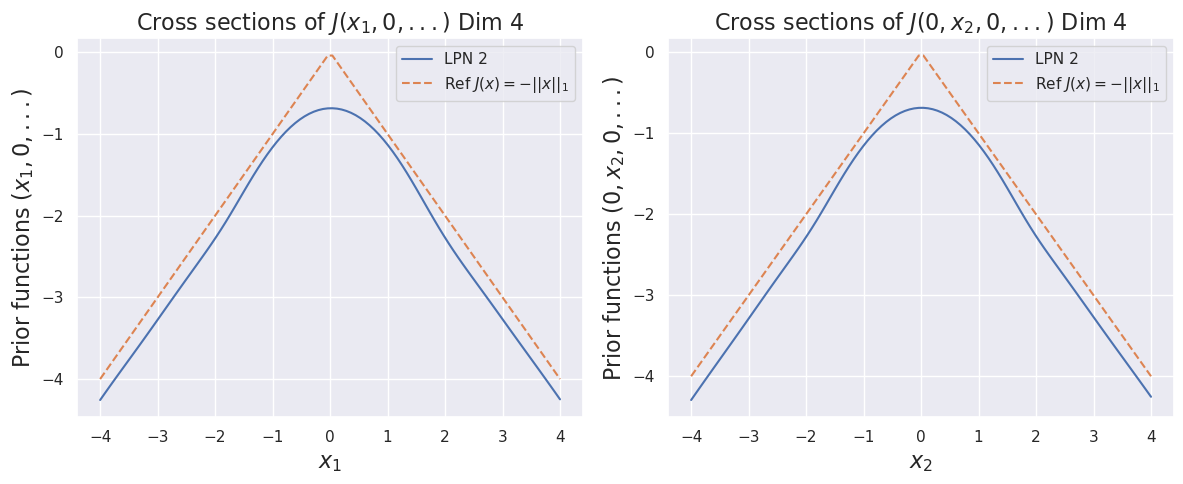

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)